**import des librairies**

In [65]:
# Les librairies
#!pip install pmdarima
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
#from statsmodels.tsa.arima.model import ARIMA
from pmdarima import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pymysql
from sqlalchemy import create_engine
import itertools
import os
from dotenv import load_dotenv

**Lecture des données de la base et mise en forme**

In [66]:
# Load environment variables from .env file
load_dotenv()

# récupération des variables d'environnement
host_opa=os.getenv('host')
user_opa=os.getenv('user')
password_opa=os.getenv('password')
database_opa=os.getenv('database')


my_conn = create_engine("mysql+pymysql://{username}:{pw}@{hostname}/{db}".format(hostname=host_opa, db=database_opa, username=user_opa, pw=password_opa))


df =pd.read_sql('SELECT close_time, close FROM history_Data WHERE symbol_id =1 AND  granularity_id =1',con=my_conn)

df = df.set_index('close_time')

#df = df.asfreq('H')
df = df.asfreq(freq='H', method='bfill')
df = df.sort_index()

print(f'valeurs manquantes: {df.isnull().any(axis=1).mean()}')
print(len(df))
df.head()

valeurs manquantes: 0.0
36098


,close
close_time,
2020-01-03 10:00:00,6506.73
2020-01-03 11:00:00,6551.62
2020-01-03 12:00:00,6565.43
2020-01-03 13:00:00,6581.57
2020-01-03 14:00:00,6581.57


**Division en jeux de données d'entraimenet et de test**

In [32]:
end_train = '2023-06-30 23:00:00'
df_train = df.loc[:end_train]
df_test  = df.loc[end_train:]

**Determination de l'ordre de différenciation  de la serie 'd'**

In [4]:
# Nombre de diff
#!pipenv install --skip-lock 
#!pip install pmdarima
from pmdarima.arima.utils import ndiffs

d=ndiffs(df.close, test='adf')
print ("nombre de diff:",d)

nombre de diff: 1


**choix des meilleurs parametres**

In [7]:
p=d=q=range(0,3)
pdq=list(itertools.product(p,d,q))
for param in pdq:
    try:
        model_arima = ARIMA(order = param)
        model_arima_fit = model_arima.fit(y=df_train)
        print(param, model_arima_fit.aic())
    except:
        continue

(0, 0, 0) 668616.6241329169
(0, 0, 1) 626948.6357582242
(0, 0, 2) 589518.8461165015
(0, 1, 0) 415463.7980138792
(0, 1, 1) 415463.1526643876
(0, 1, 2) 415454.5366746906
(0, 2, 0) 436931.4230366956
(0, 2, 1) 415466.6213836222
(0, 2, 2) 415465.65249215823
(1, 0, 0) 415486.0328819546
(1, 0, 1) 415486.5341335956
(1, 0, 2) 415478.1164862802
(1, 1, 0) 415463.24779214244
(1, 1, 1) 415453.8504724194
(1, 1, 2) 415456.07629357046
(1, 2, 0) 428312.1862016602
(1, 2, 1) 415465.8388244982
(1, 2, 2) 415470.16620187636
(2, 0, 0) 415486.59636856243


/home/jsaye/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jsaye/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0, 1) 415478.0073165911
(2, 0, 2) 415478.675850167
(2, 1, 0) 415455.27801333787
(2, 1, 1) 415456.90593942377
(2, 1, 2) 415449.276917563
(2, 2, 0) 424500.4097852275
(2, 2, 1) 415456.57917777286
(2, 2, 2) 415468.3164419417


**Entrainement du model**

On peut choisir p =0 (PACF) et q= 0 (ACF). On peut constater aussi que  l'AIF optimal est obtenue pour (0,1,0)

In [42]:

model_arima = ARIMA(order = (2,1,2))
model_arima_fit = model_arima.fit(y=df_train)
model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                30590
Model:               SARIMAX(2, 1, 2)   Log Likelihood             -207718.638
Date:                Sat, 24 Feb 2024   AIC                         415449.277
Time:                        19:45:00   BIC                         415499.247
Sample:                    01-03-2020   HQIC                        415465.296
                         - 06-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7247      0.708      1.023      0.306      -0.663       2.113
ar.L1          0.0887      0.133      0.665      0.506      -0.173       0.350
ar.L2          0.3372      0.110      3.075      0.002       0.122       0.552
ma.L1         -0.0969      0.133     -0.730      0.465      -0.357       0.163
ma.L2         -0.3602      0.109     -3.290      0.001      -0.575      -0.146
sigma2      4.635e+04    117.436    394.661      0.000    4.61e+04    4.66e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):            447904.95
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Prédiction pour comparaison avec les données de tests**

In [43]:
# Prediction
# ==============================================================================
predictions_ARIMA = model_arima_fit.predict(len(df_test))
predictions_ARIMA.name = 'predictions_ARIMA'
display(predictions_ARIMA.head(5))

2023-07-01 00:00:00    27987.971471
2023-07-01 01:00:00    27987.452128
2023-07-01 02:00:00    27988.188558
2023-07-01 03:00:00    27988.803381
2023-07-01 04:00:00    27989.830863
Freq: H, Name: predictions_ARIMA, dtype: float64

**Graphe de comparaison prédiction vs test**

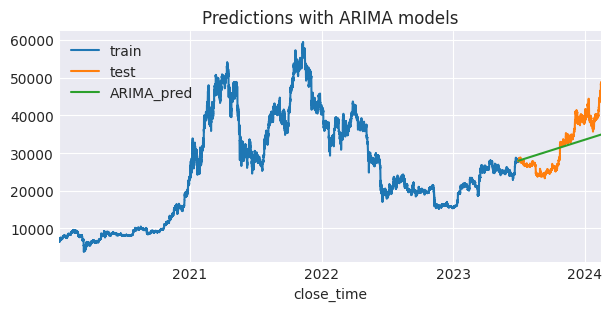

In [44]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
#df_train.plot(ax=ax, label='train')
df_train['close'].plot(ax=ax, label='train')
df_test['close'].plot(ax=ax, label='test')
predictions_ARIMA.plot(ax=ax, label='ARIMA_pred')
ax.set_title('Predictions with ARIMA models')
ax.legend();


**Re-entrainement sur tous le jeux de données**

In [46]:
model_arima = ARIMA(order = (2,1,2))
model_arima_fit = model_arima.fit(y=df)
model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                36098
Model:               SARIMAX(2, 1, 2)   Log Likelihood             -243554.604
Date:                Sat, 24 Feb 2024   AIC                         487121.208
Time:                        19:50:58   BIC                         487172.172
Sample:                    01-03-2020   HQIC                        487137.418
                         - 02-15-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1966      0.670      1.785      0.074      -0.117       2.510
ar.L1          0.1306      0.182      0.719      0.472      -0.225       0.486
ar.L2          0.2803      0.141      1.986      0.047       0.004       0.557
ma.L1         -0.1418      0.181     -0.783      0.434      -0.497       0.213
ma.L2         -0.2990      0.142     -2.103      0.035      -0.578      -0.020
sigma2      4.249e+04     97.067    437.716      0.000    4.23e+04    4.27e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            581304.85
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.35   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**prédiction pour les 6000 heures suivantes**

In [47]:
#prédiction de future valeur
pred_price= model_arima_fit.predict(6000)
#pred_price.tail()
pred_price.loc['2024-02-15 20:00:0']

48475.26435809871

**Enregistrement du model dans un fichier sur le disk**

In [48]:
import pickle
# enregistrer le model sur le disk
filename = 'ARIMA_model.sav'
pickle.dump(model_arima_fit, open(filename, 'wb'))

**Rechargement du modèl**

In [63]:
# rechargement model
loaded_model = pickle.load(open(filename, 'rb'))

pred_price1 = loaded_model.predict(5000)
pred_price1.loc['2024-02-25 20:00:00']
len(pred_price1)

5000